In [1]:
from model import ebola_model

from ema_workbench import Model, IntegerParameter, RealParameter, TimeSeriesOutcome, ScalarOutcome, Policy

model = Model('Ebola', function=ebola_model)

model.uncertainties = [IntegerParameter('I4', 1, 8),
                       IntegerParameter('I14', 20, 35),
                       IntegerParameter('I15', 25, 40),
                       RealParameter('beta_i', 0.1, 0.5),
                       RealParameter('travel_rate', 0.04, 0.1)]

model.outcomes = [ScalarOutcome('Effectiveness'),
                  ScalarOutcome('Speed'),
                  ScalarOutcome('Equity in met demand'),
                  ScalarOutcome('Equity in arrival times'),
                  ScalarOutcome('Cost per death prevented')]

model.levers = [RealParameter('exploration_ratio', 0.0, 1.0)]
                
policies = [Policy("All exploitation", **{'exploration_ratio' : 0.0})]

from ema_workbench import SequentialEvaluator

from ema_workbench import ema_logging

ema_logging.log_to_stderr(ema_logging.INFO)
'''
with SequentialEvaluator(model) as evaluator:
    experiments, outcomes = evaluator.perform_experiments(scenarios=10, policies = policies)
'''

from ema_workbench import MultiprocessingEvaluator



import time
start_time = time.time()


with MultiprocessingEvaluator(model) as evaluator:
    results = evaluator.perform_experiments(scenarios=10, policies = policies)
    
print("--- %s seconds ---" % (time.time() - start_time))

from ema_workbench import save_results
save_results(results, r'./all_exploitation_5000_2.tar.gz')
    


[MainProcess/INFO] pool started
[MainProcess/INFO] performing 10 scenarios * 1 policies * 1 model(s) = 10 experiments
[MainProcess/INFO] 1 cases completed
[MainProcess/INFO] 2 cases completed
[MainProcess/INFO] 3 cases completed
[MainProcess/INFO] 4 cases completed
[MainProcess/INFO] 5 cases completed
[MainProcess/INFO] 6 cases completed
[MainProcess/INFO] 7 cases completed
[MainProcess/INFO] 8 cases completed
[MainProcess/INFO] 9 cases completed
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] terminating pool


--- 27.374040126800537 seconds ---


In [1]:
from ema_workbench import load_results

results1 = load_results("all_exploitation_5000.tar.gz")

experiments1, outcomes1 = results1

results2 = load_results("all_exploitation_5000_2.tar.gz")

experiments2, outcomes2 = results2


In [2]:
import matplotlib.pyplot as plt

effectiveness = [outcomes1['Effectiveness'], outcomes2['Effectiveness']]
speed = [outcomes1['Speed'], outcomes2['Speed']]
equity_demand = [outcomes1['Equity in met demand'], outcomes2['Equity in met demand']]
equity_arrival = [outcomes1['Equity in arrival times'], outcomes2['Equity in arrival times']]
efficiency = [outcomes1['Cost per death prevented'], outcomes2['Cost per death prevented']]

fig = plt.figure(1, figsize=(6,30))

# Create an axes instance
ax1 = fig.add_subplot(511)
ax2 = fig.add_subplot(512)
ax3 = fig.add_subplot(513)
ax4 = fig.add_subplot(514)
ax5 = fig.add_subplot(515)


# Create the boxplot
bp1 = ax1.boxplot(effectiveness)
bp2 = ax2.boxplot(speed)
bp3 = ax3.boxplot(equity_demand)
bp4 = ax4.boxplot(equity_arrival)
bp5 = ax5.boxplot(efficiency)

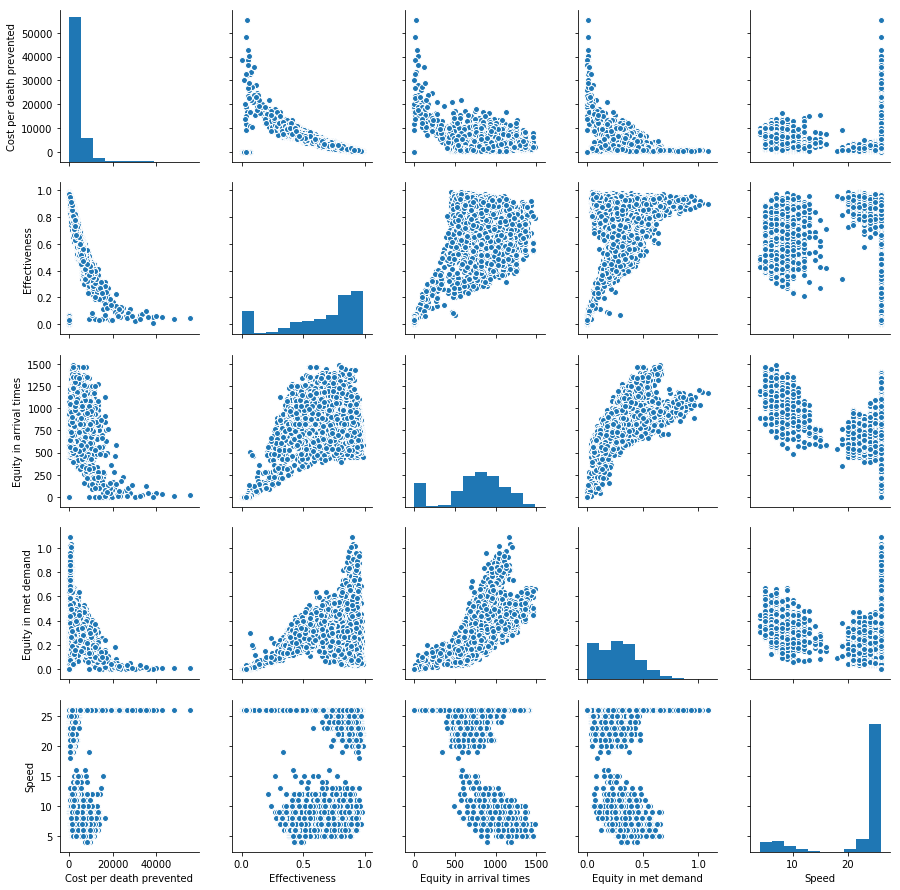

In [14]:
import pandas as pd
import seaborn as sns

sns.pairplot(pd.DataFrame.from_dict(outcomes2))
plt.show()